<center>
<h1>COMP4680/8650: Advanced Topics in Machine Learning</h1>
<h2>Assignment #6: Deep Learning Programming Assignment</h2>
</center>
    
**Due**: 11:55pm on Friday 30 October, 2020.<br>
Submit as a single Jupyter Notebook via Wattle. Make sure that your name and student ID appears in the section below.

---

**Name:** ``Sankhya Singh``
<br>
**Student ID:** ``u6737668``

---

In this assignment you will build a simple image de-noising auto-encoder neural network model using a
dataset of Pokemon characters. We will provide you with starter code using the PyTorch deep learning
library, which can be downloaded from https://pytorch.org/. Follow the installation instructions (for
the stable release, v1.6.0 at time of writing), being sure to install both `pytorch` and `torchvision`.
On Windows you may need to install the `Microsoft Visual C++ Redistributable` (you will get an error
with URL on where to find the release if not installed when you run the code below).
Browse through some of the PyTorch user documentation and tutorials.


**Run all code blocks from start to end (`Restart & Run All`) and then save your Jupyter Notebook
before submitting your assignment to ensure everything works as expected.**

In [1]:
%matplotlib notebook

import numpy as np
import numpy.random as rnd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils

from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))

GeForce 940MX


# 1. Convolutional Layers (10 marks)

The model that you will be building uses 2D convolution and transposed convolution layers.
These layers take a batch of multi-channel input images and convolve them with learnable filters
to produce a batch of multi-channel output image.
It is important that you understand how the output size is determined from the the input
size and meta-parameters (filter size, stride and padding) of the layer.
Let $(N, C_{\text{in}}, H_{\text{in}}, W_{\text{in}})$ and $(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})$
be the sizes of the input and output tensors (i.e., images batches), respectively,
where $N$ is the batch size, $C$ is the number of channels, $H$ is the tensor/image height
and $W$ is the tensor/image width. Provide written answers to the following.

**(a)** Given a $(32, 3, 64, 64)$-input, what is the size of the output for a `Conv2d` layer with $3 \times 3$ filters, 16 output channels, stride of 1, and padding of 1?

**(b)** Given a $(32, 128, 1, 1)$-input, what is the size of the output for a `ConvTranspose2d` layer with $3 \times 3$ filters, 128 output channels, stride of 1, and padding of 0?

**(c)** Given a $(32, 64, 31, 31)$-input, what is the size of the output for a `ConvTranspose2d` layer with $5 \times 5$ filters, 32 output channels, stride of 2, and padding of 0?

**(d)** How many learnable parameters are there in a `Conv2d` layer with $3 \times 3$ filters, that takes a $(32, 3, 64, 64)$-input and produces a 16-channel output?

*(provide answers here)*

# 2. Implementation (60 marks)

Your task is to implement encoder and decoder models. We have provided model templates below. Write your code in the `__init__` methods for the `Encoder` and `Decoder` classes following instructions in the `TODO` comments in the code and specification below. **Do not modify any other code.**

## 2a. Encoder (30 marks)

We will use a multi-layer perceptron to implement the encoder. In PyTorch each layer of a multi-layer perceptron is implemented using a `Linear` layer followed by an activation function layer (e.g., `ReLU` or `Tanh`). Often a `BatchNorm1d` layer is inserted between the `Linear` layer and activation function to improve training. Implement a two-layer perceptron of the following architecture:

```
Linear -> BatchNorm1d -> ReLU -> Linear -> Tanh

|---------------------------|    |------------|
        hidden layer              output layer
```

The hidden layer and output layer should both have dimensionality `z_dim`-by-1-by-1.

In [3]:
###########################################################################
# TODO: Write any helper routines for the Encoder here.                   #
###########################################################################


###########################################################################
# TODO: Complete the Encoder.                                             #
###########################################################################

class Encoder(nn.Module):
    """Encoder network to map from an RGB image to a latent feature vector."""

    def __init__(self, z_dim=64, img_size=64):
        super(Encoder, self).__init__()

        self.z_dim = z_dim
        self.hidden_layer = nn.Sequential(nn.Linear(img_size*img_size*3,128),nn.BatchNorm1d(128),nn.ReLU(True))
        self.output_layer = nn.Sequential(nn.Linear(128,128),nn.Tanh())

        


    def forward(self, x):
        x = x.view(x.size()[0], -1)
        x = self.output_layer(self.hidden_layer(x))
        return x


## 2b. Decoder (30 marks)

The decoder is implemented as a sequence of transposed and regular convolutions. The transposed convolutions have the effect of incrementally upsampling from the `z_dim`-by-1-by-1 latent representation (input to the first layer) to the 3-by-64-by-64 image (output of the last layer). The regular convolutions smooth the upsampled output. Implement the following architecture:

```
 (L1) ConvTransposed2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d -> ReLU ->
 (L2) ConvTransposed2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d -> ReLU ->
 (L3) ConvTransposed2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d -> ReLU ->
 (L4) ConvTransposed2d -> BatchNorm2d -> ReLU -> Conv2d -> Tanh
```

The specification for each layer is as follows:

<table>
    <tr>
        <td></td><td colspan=3><tt>ConvTransposed2d</tt></td><td colspan=4><tt>Conv2d</tt></td>
    </tr>
    <tr>
        <td></td><td>Filters</td><td>Kernel</td><td>Stride</td><td>Filters</td><td>Kernel</td><td>Stride</td><td>Padding</td>
    </tr>
    <tr>
        <td>Layer #1</td><td>64</td><td>15</td><td>1</td><td>64</td><td>3</td><td>1</td><td>Y</td>
    </tr>
    <tr>
        <td>Layer #3</td><td>32</td><td>3</td><td>2</td><td>32</td><td>3</td><td>1</td><td>Y</td>
    </tr>
    <tr>
        <td>Layer #4</td><td>16</td><td>3</td><td>2</td><td>16</td><td>3</td><td>1</td><td>Y</td>
    </tr>
    <tr>
        <td>Layer #5</td><td>16</td><td>2</td><td>1</td><td>3</td><td>1</td><td>1</td><td>N</td>
    </tr>    
<table>

Your code may assume that images are always 64-by-64 pixels.

In [4]:
###########################################################################
# TODO: Write any helper routines for the Decoder here.                   #
###########################################################################



###########################################################################
# TODO: Complete the Decoder.                                             #
###########################################################################

class Decoder(nn.Module):
    """Decoder network to map from a latent feature vector to an RGB image."""

    def __init__(self, z_dim=64, img_size=64):
        super(Decoder, self).__init__()

        assert img_size==64
        self.z_dim = z_dim
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(128,64,15,stride=1),nn.BatchNorm2d(64),nn.ReLU(True),nn.Conv2d(64,64,3,stride=1,padding=1),nn.BatchNorm2d(64),nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(64,32,3,stride=2),nn.BatchNorm2d(32),nn.ReLU(True),nn.Conv2d(32,32,3,stride=1,padding=1),nn.BatchNorm2d(32),nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(32,16,3,stride=2),nn.BatchNorm2d(16),nn.ReLU(True),nn.Conv2d(16,16,3,stride=1,padding=1),nn.BatchNorm2d(16),nn.ReLU(True))
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(16,16,2,stride=1),nn.BatchNorm2d(16),nn.ReLU(True),nn.Conv2d(16,3,1,stride=1,padding=0),nn.BatchNorm2d(3),nn.Tanh())

        ####################################################################
        # TODO: Create a nn.Sequential model for each layer in the decoder #
        # as described in the assignment specification. Assign them to     #
        # self.layer1, self.layer2, etc. The unit tests below will help    #
        # you check that you got the layers correct.                       #
        ####################################################################
        


    def forward(self, x):
        x = x.view(x.size()[0], self.z_dim, 1, 1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x


Run the unit tests below to check that your models are outputting the correct size tensors. Note that this does not ensure that you have correctly implemented the models, only that their output size is correct. If all the tests pass you will get a message like:

```
Ran 4 tests in 0.627s

OK
```

If one (or more) of the tests fails you will get a message with something like:

```
======================================================================
FAIL: test_layers (__main__.TestEncoder)
Test that the Encoder produces the correct size output for each layer.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-17-006c1d1d6835>", line 30, in test_layers
    self.assertEqual(tensor.size(), torch.Size([batch_size, latent_size]))
AssertionError: torch.Size([32, 256]) != torch.Size([32, 128])
----------------------------------------------------------------------
```

In this example the message is telling you that one of the layers in your Encoder is producing the wrong size output. In particular, the text is expecting a tensor of size 32-by-128 but is getting a tensor of size 32-by-256.

In [5]:
# DO NOT MODIFY ANYTHING IN THIS BLOCK

import unittest

# test encoder
class TestEncoder(unittest.TestCase):

    def test_size(self):
        """Test that the Encoder produces the correct size output."""
        batch_size = 32
        image_size = 64
        latent_size = 128
        
        E = Encoder(latent_size, image_size)
        tensor_in = Variable(2.0 * (torch.rand((batch_size, 3, image_size, image_size)) - 0.5))
        tensor_out = E.forward(tensor_in)
        self.assertEqual(tensor_out.size(), torch.Size([batch_size, latent_size]))


    def test_layers(self):
        """Test that the Encoder produces the correct size output for each layer."""
        batch_size = 32
        image_size = 64
        latent_size = 128

        E = Encoder(latent_size, image_size)
        tensor = Variable(2.0 * (torch.rand((batch_size, 3, image_size, image_size)) - 0.5))
        tensor = tensor.view(tensor.size()[0], -1)
        tensor = E.hidden_layer(tensor)
        self.assertEqual(tensor.size(), torch.Size([batch_size, latent_size]))
        tensor = E.output_layer(tensor)
        self.assertEqual(tensor.size(), torch.Size([batch_size, latent_size]))


#test decoder
class TestDecoder(unittest.TestCase):
    
    def test_size(self):
        """Test that the Decoder produced the correct size output."""
        batch_size = 32
        image_size = 64
        latent_size = 128

        D = Decoder(latent_size, image_size)
        tensor_in = Variable(2.0 * (torch.rand((batch_size, latent_size, 1, 1)) - 0.5))
        tensor_out = D.forward(tensor_in)
        self.assertEqual(tensor_out.size(), torch.Size([batch_size, 3, image_size, image_size]))


    def test_layers(self):
        """Test that the Decoder produced the correct size output for each layer."""
        batch_size = 32
        image_size = 64
        latent_size = 128

        D = Decoder(latent_size, image_size)
        tensor = Variable(2.0 * (torch.rand((batch_size, latent_size, 1, 1)) - 0.5))
        tensor = D.layer1.forward(tensor)
        self.assertEqual(tensor.size(), torch.Size([batch_size, 64, 15, 15]))
        tensor = D.layer2.forward(tensor)
        self.assertEqual(tensor.size(), torch.Size([batch_size, 32, 31, 31]))
        tensor = D.layer3.forward(tensor)
        self.assertEqual(tensor.size(), torch.Size([batch_size, 16, 63, 63]))
        tensor = D.layer4.forward(tensor)
        self.assertEqual(tensor.size(), torch.Size([batch_size, 3, image_size, image_size]))


# run tests
unittest.main(argv=['first-arg-is-ignored'], exit=False)

....
----------------------------------------------------------------------
Ran 4 tests in 0.622s

OK


# 3. Experiments (30 marks)

The code will run on a GPU if one is available and the appropriate cuda libraries are installed. Otherwise it will run on the CPU (and take much longer for training). **Make sure your code passes the unit tests above before running any of these experiments.**

The code will create a directory called `samples` and save a subset of reconstructed and randomly generated images there during training. After running the training code answer the questions below.

<IPython.core.display.Javascript object>


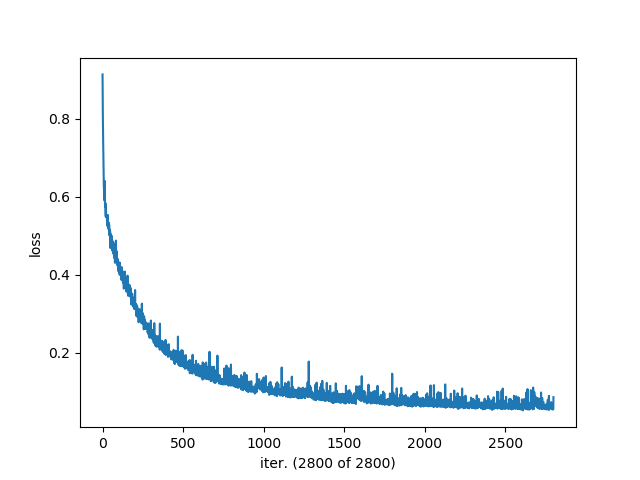

Moving models to GPU.
Started training at Wed Oct 28 13:38:27 2020
Saved samples\sample-000100.png
Saved samples\novel-000100.png
Saved samples\sample-000200.png
Saved samples\novel-000200.png
Saved samples\sample-000300.png
Saved samples\novel-000300.png
Saved samples\sample-000400.png
Saved samples\novel-000400.png
Saved samples\sample-000500.png
Saved samples\novel-000500.png
Saved samples\sample-000600.png
Saved samples\novel-000600.png
Saved samples\sample-000700.png
Saved samples\novel-000700.png
Saved samples\sample-000800.png
Saved samples\novel-000800.png
Saved samples\sample-000900.png
Saved samples\novel-000900.png
Saved samples\sample-001000.png
Saved samples\novel-001000.png
Saved samples\sample-001100.png
Saved samples\novel-001100.png
Saved samples\sample-001200.png
Saved samples\novel-001200.png
Saved samples\sample-001300.png
Saved samples\novel-001300.png
Saved samples\sample-001400.png
Saved samples\novel-001400.png
Saved samples\sample-001500.png
Saved samples\novel

In [6]:
import os
import time

# Run on GPU if available. Set to False if you want to force the models
# to stay on the CPU even if cuda is available.
RUN_ON_GPU = torch.cuda.is_available()

# Set the random seed for reproducibility
SEED = 4680

np.random.seed(SEED)
torch.manual_seed(SEED)
if RUN_ON_GPU:
    torch.cuda.manual_seed(SEED)


def np_to_var(x):
    """Converts numpy to variable."""
    if RUN_ON_GPU:
        x = x.cuda()
    return Variable(x)


def var_to_np(x):
    """Converts variable to numpy."""
    if RUN_ON_GPU:
        x = x.cpu()
    return x.data.numpy()


def get_data_loader(image_size=64, batch_size=16):
    """Creates training data loader."""
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                    transforms.RandomHorizontalFlip(0.5)
                ])

    train_dataset = datasets.ImageFolder('./data/', transform)
    return DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


# --- training code -------------------------------------------------------

def create_models(image_size=64, latent_size=128):
    """Creates encoder and decoder and moves them to the GPU if requested."""

    E = Encoder(latent_size, image_size)
    D = Decoder(latent_size, image_size)

    if RUN_ON_GPU:
        print('Moving models to GPU.')
        E.cuda()
        D.cuda()
    else:
        print('Keeping models on CPU.')

    return E, D


def train_models(E, D, image_size=64, latent_size=128, batch_size=32, num_epochs=500,
                 log_interval=10, save_interval=100, out_dir='samples', plot_fcn=None):
    """Train models."""

    # create optimizers
    e_optimizer = optim.Adam(E.parameters(), 1.0e-3, [0.5, 0.999])
    d_optimizer = optim.Adam(D.parameters(), 2.0e-3, [0.5, 0.999])

    # create output directory for image samples
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    dataloader = get_data_loader(image_size=image_size, batch_size=batch_size)
    total_train_iters = num_epochs * len(dataloader)

    loss_history = []
    print('Started training at {}'.format(time.asctime(time.localtime(time.time()))))

    # train for num_epochs
    for epoch in range(num_epochs):
        for iteration, batch in enumerate(dataloader, epoch * len(dataloader) + 1):

            real_images, _ = batch
            noisy_images = torch.clamp(torch.add(real_images, 2.0 * (torch.rand(real_images.size()) - 0.5)), min=-1.0, max=1.0)
            real_images = np_to_var(real_images)
            noisy_images = np_to_var(noisy_images)

            e_optimizer.zero_grad()
            d_optimizer.zero_grad()
            out_images = D.forward(E.forward(noisy_images))
                        
            # compute reconstruction loss and update parameters
            loss = torch.mean((real_images - out_images).abs())
            loss.backward()
            e_optimizer.step()
            d_optimizer.step()

            # keep track of loss for plotting or printing
            loss_history.append(loss.data.item())

            # print the log info
            if iteration % log_interval == 0:
                if plot_fcn is None:
                    print('Iteration [{:6d}/{:6d}] | loss: {:.4f}'.format(
                        iteration, total_train_iters, loss_history[-1]))
                else:
                    plot_fcn(loss_history, total_train_iters)

            # save the generated samples and loss
            if iteration % save_interval == 0:
                path = os.path.join(out_dir, 'sample-{:06d}.png'.format(iteration))
                torchvision.utils.save_image(torch.cat((real_images, noisy_images, out_images)),
                                             path, nrow=real_images.size()[0], normalize=True)
                print('Saved {}'.format(path))

                # generate and save some novel images
                noise = np_to_var(2.0 * (torch.rand((batch_size, latent_size, 1, 1)) - 0.5))
                novel_images = D.forward(noise)
                path = os.path.join(out_dir, 'novel-{:06d}.png'.format(iteration))
                torchvision.utils.save_image(novel_images, path, normalize=True)
                print('Saved {}'.format(path))
                
    print('Finished training at {}'.format(time.asctime(time.localtime(time.time()))))                
    return loss_history
                
# --- main ----------------------------------------------------------------

fig, ax = plt.subplots(1,1)

def plot_loss(loss, x_max=None):
    """Loss plotting."""
    ax.clear()
    ax.plot(loss)
    if x_max is not None:
        ax.set_xlabel('iter. ({} of {})'.format(len(loss), x_max))
    else:
        ax.set_xlabel('iter.')
    ax.set_ylabel('loss')
    fig.canvas.draw()

latent_size = 128
E, D = create_models(64, latent_size)
loss_curve = train_models(E, D, image_size=64, latent_size=latent_size, batch_size=32, num_epochs=400,
    log_interval=10, save_interval=100, out_dir='samples', plot_fcn=plot_loss)

## Questions

**(a)** Comment on whether you think training has converged. Why?

**(b)** Look at the `sample-*.png` images. These show the ground-truth images, noisy input images, and denoised images for the mini-batch. Comment on the quality of the denoised images as training progresses.

**(c)** Look at the `novel-*.png` images. These show images generated from random noise injected into the decoder model. Comment on the quality of the generated images as training progresses.

**(d)** Play around with your encoder and decoder models (they no longer need to pass the unit tests). Report any interesting findings (one or two paragraphs).

*(provide answers here)*